# Exact Ising Model Computations for Small Lattices

It will be helpful to have exact results at hand to benchmark our Monte Carlo techniques. To obtain these for small square lattices with $L = 2,3,4$, we enumerate the set of all $2^{L^2}$ spin configurations, define the partition function and other thermodynamic functions on this set, and compute corresponding thermal averages. 

It is additionally useful to compute the density of states in this fashion. The computation quickly becomes prohibitively costly for $L >5$. However, see this [article](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.76.78) on the exact density of states for square lattice nearest neighbor Ising model. See [link](https://spot.colorado.edu/%7Ebeale/MathematicaFiles/) for Mathematica notebooks which compute the exact results for a given $n \times m$ lattice. See also this [stack exchange discussion](https://physics.stackexchange.com/questions/335631/ising-model-density-of-states) on enumerating the density of states for $d=1,2$.

For performing a maximum likelihood estimation of the temperature, we will need probablity and log probabilities of specific energies as well as samples of energies. We detail some of this below.

The probabiltiy of a given energy observation is $p(E_k)=\mathcal{Z}(\beta)^{-1}\exp(-\beta E_k)$. Thus, for a random (independent) sample $\{E_i\}_{i=1,N}$, $p(\{X_i\})=\mathcal{Z}(\beta)^{-N}\exp(-\beta \sum_{i=1}^N E_i)$. Or in terms of the sample mean, $p(\bar{E})=\mathcal{Z}(\beta)^{-N}\exp(-\beta N \bar{E})$. This is all well and good for non-degenerate systems, but there is degeracy here since there are multiple configurations (states) which correspond to the same energy. 

To account for this, we introduce a multiplicative factor $\Omega(E)$ which counts the number of states with energy $E$:

\begin{eqnarray}
p(E_k)=\mathcal{Z}(\beta)^{-1}\sum_{E=E_k}\exp(-\beta E)=\mathcal{Z}(\beta)^{-1}\Omega(E_k)\exp(-\beta E_k)
\end{eqnarray}

So then the probability of measuring a sample $\{E_i\}_{i=1,N}$ becomes

\begin{eqnarray}
p(\bar{E})&=& \Pi_{i=1}^N p(E_i)=\mathcal{Z}(\beta)^{-N}\Pi_{i=1}^N \Omega(E_i)\exp(-\beta E_i)
\end{eqnarray}

### Configuration generator and binary representation map for configurations

In [ ]:
import itertools, numpy as np

def config_gen(L):
    '''Function to generate all lattice configurations for a given linear size L '''
    perm = [list(seq) for seq in itertools.product("ab", repeat=L*L)]
    perm = np.array(perm).reshape(2**(L*L), L, L)
    perm = np.where(perm=="a", 1, -1)
    return perm

def binary_rep(M):
    ''' Function to map configurations to binary then a number between 0 and 2**N-1  '''
    N=np.shape(M)[0]
    M=np.reshape(M,N*N)
    M=np.where(M==-1,0,1)
    return sum([M[i]*2**i for i in range(len(M))])

### Ising model Hamiltonian

In [ ]:
def Ham(Latt,H):
    ''' The Hamiltonian for a square LxL lattice Ising model with
    nearest neighbor interactions and magnetic field H. We take J=1 and use scaled temperature $T=J/T$ '''
    J = 1
    L = len(Latt) 
    Sum_H = -H*np.sum(Latt)
    Sum_J = 0
    for i in range(L):
        for j in range(L):
            # move through lattice and compute s_i * neighbors
            Sum_J += -J * Latt[i, j] * (Latt[(i+1)%L, j] + Latt[(i-1)%L, j]
                                        + Latt[i, (j+1)%L]+ Latt[i, (j-1)%L])
    return ( Sum_J/2 + Sum_H )

### Functions determining degeneracy and probablity distribution of energies

In [ ]:
def E_list(L):
    ''' Computes nearest neighbor energies for all configurations for a given N at H=0'''
    return [Ham(M,0) for M in config_gen(L)]

def deg_E(L): 
    ''' Counts occurences of each E in E_list(N), returns the set of (E, deg(E)) '''
    el = E_list(L)
    degen = sorted([ (x,el.count(x)) for x in set(el)])
    #return [ i for i,j in degen]
    return degen

def degen_gen(E,L): 
    ''' Degenracy computation. This is too slow. Best to compute once degen_set and use in later functions'''
    degen_set = np.array(deg_E(L))
    i = np.where(degen_set[:,0] == E)[0][0]
    return degen_set[i][1]

In [ ]:
# functions below use a global precomputed result for the energies and degeneracies for $L=2,3,4$
# In this cell, we compute once and for all the degeneracies used 

E_set = [ set(E_list(n)) for n in [2,3,4]]
degen_set = [deg_E(n) for n in [2,3,4]]

In [ ]:
# def part_func(L,T,H):
#     ''' The partition function for a square LxL lattice, 
#     nearest neighbor interactions, at temperature T and magnetic field H '''
    
#     return np.sum([np.exp(-1/T*Ham(M,H)) for M in config_gen(L) ])

def prob_E(L,T,H,E):
    ''' A function to the compute probabiliy of given energy E of 
    a square LxL lattice, nearest neighbor interactions, at temperature T and magnetic field H '''
    
    i = [2,3,4].index(L)
    degen_set_here = np.array(degen_set[i])
    if H != 0:
        el = [ Ham(M,H) for M in config_gen(L)]
        degen_set_here = np.array([ (x,el.count(x)) for x in set(el)])
    def degen(Es):
        j = np.where(degen_set_here[:,0] == Es)[0][0]
        return degen_set_here[j][1]
    part_func = np.sum( [g*np.exp(-1/T*e) for e,g in degen_set_here])
    return part_func**(-1)*degen(E)*np.exp(-1/T*E)

def prob_Eset(L,T,H,E_samples): 
    ''' A function to compute the probabiliy of a given sample of energies E_samples
    of a square LxL lattice, nearest neighbor interactions, at temperature T and magnetic field H '''

    n = len(E_samples)
    i = [2,3,4].index(L)
    degen_set_here=np.array(degen_set[i])
    if H != 0:
        el = [ Ham(M,H) for M in config_gen(L)]
        degen_set_here = np.array([ (x,el.count(x)) for x in set(el)])
    def degen(Es):
        j = np.where(degen_set_here[:,0] == Es)[0][0]
        return degen_set_here[j][1]
    part_func = np.sum( [g*np.exp(-1/T*e) for e,g in degen_set_here])
    return part_func**(-n)*np.prod( [(degen(e)*np.exp(-1/T*e))**(E_samples.count(e)) for e in set(E_samples) ] )

def log_prob_Eset(L,T,H,E_samples):
    ''' A function to compute the log-probabiliy of a given sample of energies E_samples
    of a square LxL lattice, nearest neighbor interactions, at temperature T and magnetic field H '''

    n = len(E_samples)
    i = [2,3,4].index(L)
    degen_set_here = np.array(degen_set[i])
    if H != 0:
        el = [ Ham(M,H) for M in config_gen(L)]
        degen_set_here = np.array([ (x,el.count(x)) for x in set(el)])
    def degen(Es):
        j = np.where(degen_set_here[:,0] == Es)[0][0]
        return degen_set_here[j][1]
    part_func = np.sum( [g*np.exp(-1/T*e) for e,g in degen_set_here])
    return -n*np.log(part_func) + np.sum([E_samples.count(E)*(-1/T*E +np.log(degen(E))  ) for E in set(E_samples) ])     

In [ ]:
# def mean_E(L,T,H):
#     ''' Computes mean energy for (L,T,H)'''
#     i = [2,3,4].index(L)
#     el = sorted(list(set(E_list(L))))
#     degen_set_here = np.array(degen_set[i])
#     if H != 0:
#         el = [ Ham(M,H) for M in config_gen(L)]
#         degen_set_here = np.array([ (x,el.count(x)) for x in set(el)])
#     def degen(Es):
#         j = np.where(degen_set_here[:,0] == Es)[0][0]
#         return degen_set_here[j][1]
#     return part_func(L,T,H)**(-1)*np.sum([e*degen(e)*np.exp(-1/T*e) for e in el])

# def var_E(L,T,H):
#     '''Computes variation of energy for (L,T,H)'''
#     i = [2,3,4].index(L)
#     el = sorted(list(set(E_list(L))))
#     e_mean = mean_E(L,T,H)
#     degen_set_here=np.array(degen_set[i])
#     if H != 0:
#         el = [ Ham(M,H) for M in config_gen(L)]
#         degen_set_here = np.array([ (x,el.count(x)) for x in set(el)])
#     def degen(Es):
#         j = np.where(degen_set_here[:,0] == Es)[0][0]
#         return degen_set_here[j][1]
#     return part_func(L,T,H)**(-1)*np.sum([(e-e_mean)**2*degen(e)*np.exp(-1/T*e) for e in el])

Energy list:  [-32.0, -24.0, -20.0, -16.0, -12.0, -8.0, -4.0, 0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0, 32.0]


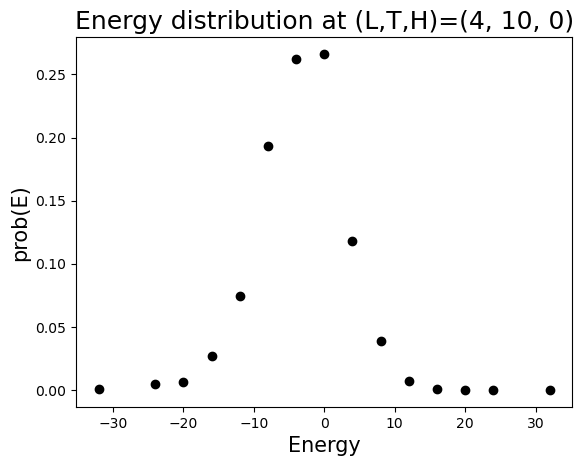

In [ ]:
import matplotlib.pylab as plt

## compute histrogram and exact probablities
#elist = list(sorted(set([ Ham(M,J_NN,H) for M in config_gen(N)])))
L, T, H = 4, 10, 0
beta = 1/T
N_sites = L**2

elist = [Ham(M,H) for M in config_gen(L)]
eset = sorted(set(elist))
degeneracies = np.array([ (e, elist.count(e)) for e in eset])

partition_function = np.sum([np.exp(-1/T*e) for e in elist ])
prob_set = np.zeros_like(eset)
for i,e in enumerate(eset):
    j = np.where(degeneracies[:,0] == e)[0][0]
    degen = degeneracies[j][1]
    prob_set[i] = partition_function**(-1)*degen*np.exp(-1/T*e)

E_mean = np.sum( [e*p for e,p in zip(eset,prob_set)] )

print("Energy list: ", eset)
fig, ax = plt.subplots(1,1)
ax.scatter(eset, prob_set, color = "black", label = "Theory") 
ax.set_xlabel("Energy",fontsize = 15) 
ax.set_ylabel("prob(E)" ,fontsize = 15)
plt.title(f"Energy distribution at (L,T,H)={(L,T,H)}",fontsize=18)
plt.show()

Energy list:  [-32.16, -31.84, -24.14, -23.86, -20.12, -19.88, -16.12, -16.1, -16.08, -16.0, -15.92, -15.9, -15.88, -12.1, -12.08, -12.06, -12.04, -12.02, -11.98, -11.96, -11.94, -11.92, -11.9, -8.1, -8.08, -8.06, -8.04, -8.02, -8.0, -7.98, -7.96, -7.94, -7.92, -7.9, -4.08, -4.06, -4.04, -4.02, -4.0, -3.98, -3.96, -3.94, -3.92, -0.08, -0.06, -0.04, -0.02, 0.0, 0.02, 0.04, 0.06, 0.08, 3.94, 3.96, 3.98, 4.0, 4.02, 4.04, 4.06, 7.94, 7.96, 7.98, 8.0, 8.02, 8.04, 8.06, 11.96, 11.98, 12.0, 12.02, 12.04, 15.96, 15.98, 16.0, 16.02, 16.04, 20.0, 23.98, 24.02, 32.0]


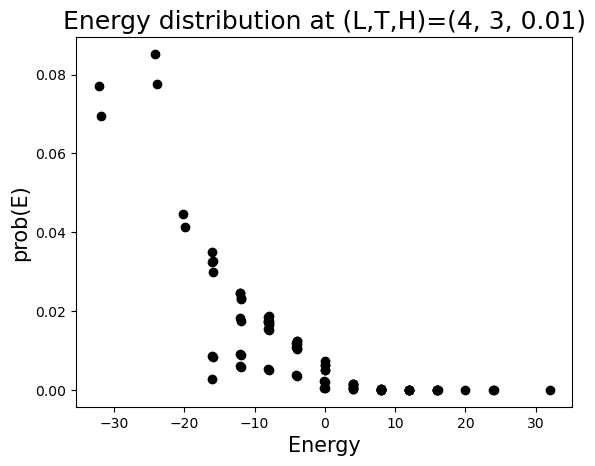

In [ ]:
## compute histrogram and exact probablities
#elist = list(sorted(set([ Ham(M,J_NN,H) for M in config_gen(N)])))
L, T, H = 4, 3, 0.01
beta = 1/T
N_sites = L**2

elist = [Ham(M,H) for M in config_gen(L)]
eset = sorted(set(elist))
degeneracies = np.array([ (e, elist.count(e)) for e in eset])

partition_function = np.sum([np.exp(-1/T*e) for e in elist ])
prob_set = np.zeros_like(eset)
for i,e in enumerate(eset):
    j = np.where(degeneracies[:,0] == e)[0][0]
    degen = degeneracies[j][1]
    prob_set[i] = partition_function**(-1)*degen*np.exp(-1/T*e)

E_mean = np.sum( [e*p for e,p in zip(eset,prob_set)] )

print("Energy list: ", eset)
fig, ax = plt.subplots(1,1)
ax.scatter(eset, prob_set, color = "black", label = "Theory") 
ax.set_xlabel("Energy",fontsize = 15) 
ax.set_ylabel("prob(E)" ,fontsize = 15)
plt.title(f"Energy distribution at (L,T,H)={(L,T,H)}",fontsize=18)
plt.show()

# Computational Complexity of Lattice Functions

Below we will demonstrate that for nearest neighbor interaction, we can reduce the complexity of the spin-flip energy computation from $\mathcal{O}(N^2)$ to $\mathcal{O}(1)$. The $L^2$ behavior is due to the scan over the 2D lattice to find the neareast neighbors. Computing the Hamiltonaian this way (which is neccesary for general spin interactions) would have an even larger dependence on L - $\mathcal{O}(L^4)$ due to summing interaction of each of the $L^2$ spins with all $L^2$ other spins. 

### Spin flip energy change (poor and best implemenation)

In [ ]:
def spin_flip_poor(M,H,u):
    a,b = u
    L = len(M)
    Sum_H = -H*M[a,b]
    Sum_J = 0
    for i in range(L):
        for j in range(L):
            v = np.array([i,j])
            if (i == a and j == b+1) or  (i == a and j == b-1) or (i == a+1 and j == b) or (i == a-1 and j == b):
                Sum_J += - J*M[a,b]*M[i%L, j%L]
    return ( Sum_J/2 + Sum_H )

def spin_flip(M,H,u):
    a,b = u
    L = len(M)
    Sum_H = -H*M[a,b]
    Sum_J = - J*M[a,b]*(M[a, (b+1)%L] + M[a,(b-1)%L] + M[(a+1)%L,b] + M[(a-1)%L,b] )
    return ( Sum_J + Sum_H )

In [ ]:
from scipy.optimize import curve_fit
import matplotlib.pylab as plt
from time import time

N_check=10000
N_range=np.arange(2,40,2)
time_data=[0 for N in N_range]

for i in range(len(N_range)):
    N=N_range[i]
    t0=time()
    [spin_flip(coldstart(N),0,[1,1]) for i in range(N_check)]
    t1=time()
    time_data[i]=(t1-t0)/N_check
    #print((t1-t0)/N_check)

y = 2.213093688938631e-06 + -2.0378556079555698e-08 x


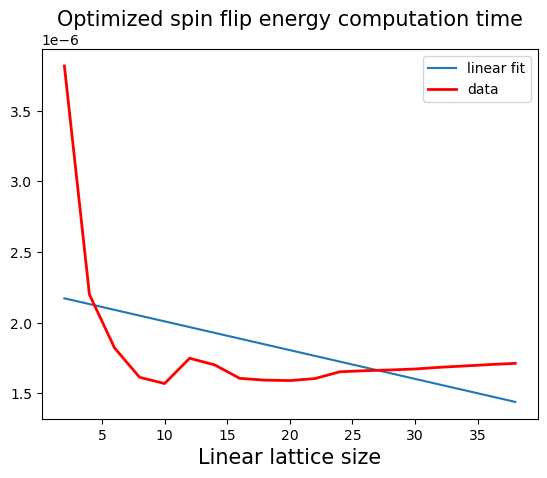

In [ ]:
par,con=curve_fit((lambda x,a,b: a+b*x),N_range,time_data)
a,b=par
print(f"y = {a} + {b} x")

fig, ax = plt.subplots(1,1)
ax.plot(N_range, (lambda x,a,b: a+b*x)(N_range,a,b), label="linear fit")
ax.plot(N_range, time_data, linewidth=2, color='r', label="data")
ax.set_xlabel("Linear lattice size",fontsize=15) 
ax.set_title("Optimized spin flip energy computation time" ,fontsize=15)
plt.legend()
plt.show()

In [ ]:
N_check=10000
N_range=np.arange(2,20,2)
time_data=[0 for N in N_range]
for i in range(len(N_range)):
    N=N_range[i]
    t0=time()
    [spin_flip_poor(coldstart(N),0,[1,1]) for i in range(N_check)]
    t1=time()
    time_data[i]=(t1-t0)/N_check
    #print((t1-t0)/N_check)

y=2.584985442587021e-07x^2+1.4039010500451102e-07x+2.925868155680966e-06


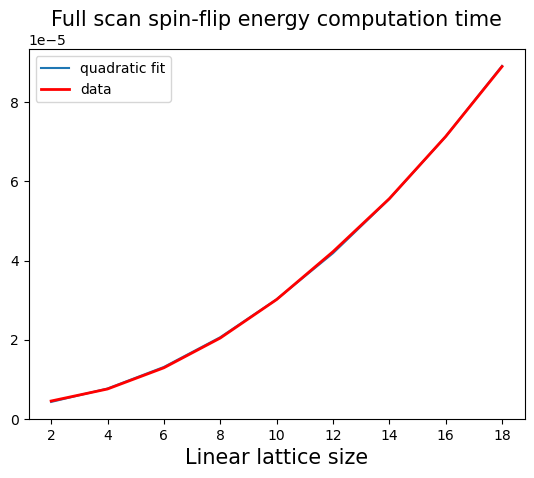

In [ ]:
par,con=curve_fit((lambda x,a,b,c:a*x**2+b*x+c),N_range,time_data)
a,b,c=par
print(f"y={a}x^2+{b}x+{c}")

fig, ax = plt.subplots(1,1)
ax.plot(N_range,(lambda x,a,b,c:a*x**2+b*x+c)(N_range,a,b,c), label="quadratic fit")
ax.plot(N_range,time_data,linewidth=2, color='r', label="data")
ax.set_xlabel("Linear lattice size",fontsize=15) 
ax.set_title("Full scan spin-flip energy computation time" ,fontsize=15)
plt.legend()
plt.show()